Using the same methodology, we can adapt the particle filter function to handle 2-Dimensional models.

We will use a stochastic differential equation (SDE) of the form $dX(t) = \mu(X(t), t)dt + \sigma(X(t), t) d\beta t$ to represent a model for movement. 

To approximate the SDE, we use the Euler-Maruyama method that recursively defines the states as

$$X_{t+1} = X_t + \mu(X_t)\Delta t + \sigma \Delta W_n$$

The first function below, $muFnc$, calculates $\mu(X_t)$, the expected movement given current location ($loc$) and the expected movement direction ($driftParam$). Currently, the output of $muFnc$ does not depend on the location parameter, and only returns $driftParam$. 

The next function $x\_t\_2D$, calculates the next state $X_{t+1}$ given paramaters $loc$ (the current state $X_t$), $timePart$ (the time difference between $X_{t+1}$ and $X_t$), and $diffVar$ (variance parameter, $\sigma^2$).

The function $y\_t\_2D$ calculates the measurements given $loc$. We observe the true states $X_t$ with error, so the measurements are denoted $Y_t = X_t + \epsilon_t$ where $\epsilon_t \sim Normal(0, 5)$.

Lastly, the function $x\_0\_2D$ calculates the initial location by sampling from a uniform random variable.

In [1]:
# mu function that defines expected movement
function muFnc(loc, driftParam)
    latMov = driftParam[1]
    longMov = driftParam[2]
    return [latMov, longMov]
end

# calculate next location
function x_t_2D(loc, timePart, diffVar)
    return loc + muFnc([0,0], [5,5]).*timePart + sqrt(diffVar).*sqrt(timePart).*rand(MvNormal(eye(2)))
end

# measurement
function y_t_2D(loc)
    return loc + rand(Normal(0,5), 2)
end

# initial location, sample from Unif(-100, 100)
function x_0_2D()
    return rand(Uniform(-100, 100), 2) 
end


x_0_2D (generic function with 1 method)

Data is generated at successive times $t_1, t_2, ....$ where the difference between successive times is given by an expononential random variable with rate $timeParam$.

The parameter $tt$ is the number of observations to be generated. At each iteration:
* The time between observations is determined by sampling from an exponential random variable, and is denoted by $timePart$
* The next location/state is calculated using $x\_t\_2D$ and is stored in the state vector $x$
* The corresponding measurement is calculated using $y\_t\_2D$ and is stored in the measurement vector $y$
* The successive times are stored in the vector $timeParts$



In [2]:
using Distributions

# timeParam = parameter for exponential draws of time between observations
# diffVar = variance parameter for diffusion (sigma^2)
# driftParam = expected movement direction (long, lat)
function generate_data_2D(timeParam, diffVar, driftParam, tt)
    t = 0.0
    initialLoc = x_0_2D()         #initial state
    x = Array{Float64}(tt, 2)      #states
    y = Array{Float64}(tt, 2)       #measurements
    timeParts = Array{Float64}(tt)
    previousLoc = initialLoc
    
    for i in 1:tt
        timePart = rand(Exponential(1), 1)
        newLoc = x_t_2D(previousLoc, timePart, diffVar)
        newObs = y_t_2D(newLoc)
        t = t + timePart                                        
        x[i,1:2] = newLoc
        y[i,1:2] = newObs
        timeParts[i] = timePart[1]
        previousLoc = newLoc
    end
    return [x, y,timeParts]
end

# x,y, t = test(5, 5, [5,5], 100)

# using PyPlot
# fig, ax = subplots()
# ax[:plot](x[1:100, 1], x[1:100, 2], marker = ".",color="blue")
# ax[:plot](y[1:100, 1], y[1:100, 2], marker = ".",color="red")

generate_data_2D (generic function with 1 method)

The $generate\_data$ function returns the array of states, array of measurements, and array of times between observations.

The implementation of the particle filter follows the same steps as in the one-dimensional case:
1. Start by initializing the $N$ particles using the function $x\_0\_2D$. Each of the $N$ particles is a two dimensional vector, so $x\_pre$ is an $N x 2$ matrix.
2. At each time step:

    (1) Move each particle according to $x\_t\_2D$, using the same time differences as the previously generated data.
    
    (2) Compute the weights of each particle using function $conditional\_likelihoods\_2D$. Because the latitude and longitude values are independent, the joint likelihood is calculated by multiplying the likelihood of the latitude (based on the latitude of the measurement) and the likelihood of the longitude (based on the longitude of the measurement). 
    
    (3) Normalize the weights so that they add up to 1.
    
    (3) Resample from $x\_k\_pre$ using the normalized weights.
    
    (4) The mean latitute and mean longitude of the particles become the estimate of the location

In [3]:
function conditional_likelihoods_2D(y, x)
    diff = hcat(x[:,1] - y[1], x[:,2] - y[2])
    likelihoods = hcat(pdf(Normal(0,5), diff[:,1]), pdf(Normal(0,5), diff[:,2]))
    return likelihoods[:,1] .* likelihoods[:,2]
end

conditional_likelihoods_2D (generic function with 1 method)

In [4]:
function particle_filter_2D(data, x_0_2D, x_t_2D, conditional_likelihoods_2D, N, tt)
    x_post = Array{Float64}(tt,2)    # initialize x_post
    x = data[1]                           # states
    y = data[2]                           # observations
    timeParts = data[3]
    x_pre = Array{Float64}(N, 2)  # Initialization
    for i in 1:N
        x_pre[i, 1:2] = x_0_2D()
    end
    
    for k = 1:tt
        x_k_pre = Array{Float64}(N, 2)
        for i in 1:N
            x_k_pre[i,:] = x_t_2D(x_pre[i,:], timeParts[k], 5)
        end
        likelihood = conditional_likelihoods_2D(y[k,:],x_k_pre)
        total = sum(likelihood)       # Normalization: normalize weights so that they sum to 1
        likelihood = likelihood./total
        index = wsample(1:N, likelihood, N)
        x_k_post = x_k_pre[index, :]
        x_post[k,:] = [mean(x_k_post[:,1]), mean(x_k_post[:,2])]
        x_pre = x_k_post
    end
    return x_post
end


particle_filter_2D (generic function with 1 method)

Now we can simulate data and see how well the particle filter performs. 

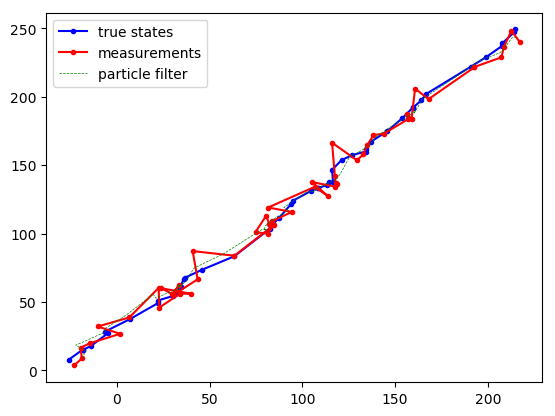

5.906128311876862
3.5326832271057964


PyObject <matplotlib.legend.Legend object at 0x000000001FCF9E48>

In [6]:
srand(2)
data = generate_data_2D(5, 5, [5,5], 50)
pred = particle_filter_2D(data, x_0_2D, x_t_2D, conditional_likelihoods_2D, 200, 50)

x = data[1]
y = data[2]

mse = 0
mse_pf = 0
for i in 1:50
    mse = mse + norm(y[i,:] - x[i,:])
    mse_pf = mse_pf + norm(pred[i,:] - x[i,:])
end
mse = mse/50
mse_pf = mse_pf/50

println(mse)
println(mse_pf)

using PyPlot
fig, ax = subplots()
ax[:plot](x[:,1], x[:,2], marker = ".",color="blue", label = "true states")
ax[:plot](y[:,1], y[:,2], marker = ".",color="red", label = "measurements")
ax[:plot](pred[:,1], pred[:,2], "g--", linewidth = 0.5, label = "particle filter")
legend()

The particle filter reduces the mean normalized error by 36%